<a href="https://colab.research.google.com/github/mohamedseklani/Group-A-DLI-Assignment/blob/main/M_seklani(NB).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# import the packages to be used
import os       # to create directories and remove files
import numpy as np
import pandas as pd
import random

# set the random seed to ensure the result is reproducible
random.seed(10)
np.random.seed(10)

In [37]:
# ==========================================
# 2. Unzip all csv files
# ==========================================
import os, zipfile, random, pandas as pd

zip_folder = "Dataset/LUFlow/2020/07"
extract_folder = zip_folder

for zip_file in os.listdir(zip_folder):
    if zip_file.endswith(".zip"):
        with zipfile.ZipFile(os.path.join(zip_folder, zip_file), 'r') as z:
            z.extractall(extract_folder)

print("✅ All files extracted!")

# ==========================================
# 3. Combine all csv files into one
# ==========================================
def combine_csv_files(dataset_folder: str, reduce_sample_size: bool = False):
    combined_path = f"Dataset/dataset_combined/LUFlow_2020_07.csv"
    os.makedirs("Dataset/dataset_combined", exist_ok=True)

    # Remove old file if exists
    if os.path.isfile(combined_path):
        os.remove(combined_path)

    for i, file in enumerate(sorted(os.listdir(dataset_folder))):
        if not file.endswith(".csv"):
            continue
        with open(os.path.join(dataset_folder, file), "r") as infile, open(combined_path, "a") as outfile:
            for j, line in enumerate(infile):
                if 'Label' in line or 'label' in line:  # header
                    if i != 0 or j != 0:
                        continue
                elif reduce_sample_size and random.randint(1, 10) > 1:
                    continue
                outfile.write(line.replace(' ï¿½ ', '-'))

    print(f"✅ Combined CSV saved to {combined_path}")
    return combined_path

combined_csv = combine_csv_files("Dataset/LUFlow/2020/07")

# ==========================================
# 4. Load into pandas
# ==========================================
df = pd.read_csv(combined_csv)
print("Dataset shape:", df.shape)
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'Dataset/LUFlow/2020/07'

Step 2. Preliminary analysis

In [ ]:
# read the dataset
luflow2020 = pd.read_csv('/content/Dataset/dataset_combined/LUFlow_2020_07.csv')
luflow2020.head()

In [ ]:
print(f"Number of rows: {luflow2020.shape[0]}")
print(f"Number of columns: {luflow2020.shape[1]}")

In [ ]:
print("Columns in the dataset:")
luflow2020.columns

In [ ]:
print('Class distribution:')
luflow2020['label'].value_counts()

In [ ]:
print('Class distribution (normalized):')
luflow2020['label'].value_counts()/luflow2020.shape[0]*100

Check for null value

In [ ]:
luflow2020_null_count = luflow2020.isnull().sum()
luflow2020_null_count = luflow2020_null_count[luflow2020_null_count > 0]
print(f"Rows contain null value: \n{luflow2020_null_count}\n")

luflow2020_null_count = luflow2020_null_count / luflow2020.shape[0] * 100
print(f"Rows contain null value (percentage): \n{luflow2020_null_count}\n")

Check for infinity value

In [ ]:
print('Number of samples contains infinity value:')
np.isinf(luflow2020.iloc[:, :-2]).any(axis=1).sum()

Check for columns that contain string values

In [ ]:
luflow2020.info()

Check for duplicates

In [ ]:
# check for duplicated column
luflow2020.columns[luflow2020.columns.value_counts() > 1]

In [ ]:
luflow_duplicates = luflow2020[luflow2020.duplicated()]
print(f"{luflow_duplicates.shape[0]} rows are duplicates")
print(f"{luflow_duplicates.shape[0]/luflow2020.shape[0]*100:.2f}% of rows are duplicates")

Step 3. Dataset cleaning

In [ ]:
# remove rows contain missing value
luflow2020 = luflow2020.dropna(how='any')
luflow2020.shape

In [ ]:
luflow2020 = luflow2020.drop_duplicates()
luflow2020.shape

Step 4. Dataset preparation

In [ ]:
attack = luflow2020[luflow2020['label']=='malicious']
benign = luflow2020[luflow2020['label']=='benign'].sample(n=len(attack)).reset_index(drop=True)

luflow2020_exclude_outlier = pd.concat([attack, benign])
del attack
del benign

luflow2020_exclude_outlier['label'].value_counts()

Step 5. Save the dataset

In [ ]:
# function to save the cleaned dataset
def save_cleaned_dataset(dataframe: pd.DataFrame,dataset: str, tag: str = ""):
    # create a new directory to save the cleaned dataset
    os.makedirs('./Dataset/dataset_cleaned', exist_ok=True)

    if not(tag == ""):
        tag = "_" + tag

    dataframe.to_csv(f'Dataset/dataset_cleaned/{dataset}{tag}.csv', index=False)

In [ ]:
save_cleaned_dataset(dataframe=luflow2020_exclude_outlier, dataset='LUFlow')

Feature Selection

In [ ]:
# import all necessary packages

# basic packages for data processing
import os       # to create directories and remove files
import pandas as pd
import numpy as np
import random # import random package to specify the random seed

# modules for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# modules to interpret the training result
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

# silent the warning from the sklearn library
import warnings
warnings.filterwarnings('ignore')

# set the random seed to ensure the result is reproducible
random.seed(10)
np.random.seed(10)

In [ ]:
# load the dataset
luflow = pd.read_csv('Dataset/dataset_cleaned/LUFlow.csv')
luflow = luflow.sample(frac=0.05).reset_index(drop=True)
luflow.shape

In [ ]:
luflow['time_between'] = luflow['time_end'] - luflow['time_start']

luflow[['time_start', 'time_end', 'time_between', 'duration']]

In [ ]:
luflow = luflow.drop(['src_ip', 'dest_ip', 'time_start', 'time_end', 'time_between'], axis=1)
luflow.head()

In [ ]:
# seperate the features and the output variables into two dataframe
luflow_X = luflow.drop('label', axis=1).copy()
luflow_y = luflow['label'].copy()

In [ ]:
%%time

rfc = RandomForestClassifier()
rfc.fit(luflow_X, luflow_y)

In [ ]:
#extract the importance score
score = np.round(rfc.feature_importances_, 3)
importance = pd.DataFrame({'feature': luflow_X.columns,
                             'importance score': score})
importance = importance.sort_values('importance score', ascending=False).set_index('feature')

print(f"Top features: \n{importance}")

plt.rcParams['figure.figsize'] = (12, 4)
importance.plot.bar()

In [ ]:
def save_feature(features: pd.Series, dataset_name: str, algorithm: str, tag: str = ""):

    feature_count = features.shape[0]

    if not(tag == ""):
        tag = "_" + tag

    directory = 'Dataset/features_selected'
    file_name = f"{dataset_name}_{algorithm}_{feature_count}{tag}"

    # create directory to save the file
    os.makedirs(directory, exist_ok=True)

    features.to_csv(f"{directory}/{file_name}.csv", index=False, columns=None)

    print(f"The features have been saved in {directory}/{file_name}.csv")

In [ ]:
# save the ranking of the features in a CSV file
features = pd.Series(importance.index[:], dtype='str')
save_feature(features=features,
            dataset_name='LUFlow',
            algorithm='RandomForestClassifier')

In [ ]:
# define ML models without optimized hyperparameter
models = {
    'Naive Bayes': GaussianNB()
}

In [ ]:
luflow_train_X, luflow_test_X, luflow_train_y, luflow_test_y = train_test_split(luflow_X, luflow_y, test_size=0.3)

In [ ]:
feature_set = []
scalar = StandardScaler()
scores = []

for feature in features:
    feature_set.append(feature)
    print(f"Added feature {len(feature_set)} ({feature}) ...")

    test_X = luflow_test_X[feature_set]
    train_X = luflow_train_X[feature_set]

    # scale the dataset
    train_X_scaled = scalar.fit(train_X)
    train_X_scaled = scalar.transform(train_X)
    test_X_scaled = scalar.transform(test_X)

    score_temp = [len(feature_set)]

    for model in models:
        clf = models[model]
        clf.fit(train_X_scaled, luflow_train_y)

        prediction = clf.predict(test_X_scaled)
        accuracy = metrics.accuracy_score(luflow_test_y, prediction)

        score_temp.append(accuracy)

    scores.append(score_temp)


scores = np.array(scores)

In [ ]:
plt.figure(figsize=(15, 10))
for index, model in enumerate(models):
    plt.plot(scores.T[0], scores.T[index + 1], label=model)

plt.rcParams.update({'font.size': 13})
plt.title('Accuracy of the models with respect to the number of features')
plt.xlabel('Number of features')
plt.ylabel('Accuracy score')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# import all of the packages that will be used

# basic packages for data processing
import pandas as pd
import numpy as np

# packages for machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# packages to interpret the training result
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

# set the random seed to ensure the result is reproducible
import random
random.seed(10)
np.random.seed(10)

In [ ]:
features = pd.read_csv('/content/LUFlow.csv').squeeze()
features = features[:6]

In [ ]:
columns = features.tolist() +  ['label']

luflow2020 = pd.read_csv('/content/LUFlow_RandomForestClassifier_11.csv', usecols=columns)
luflow2020.shape

In [ ]:
luflow2020 = luflow2020.sample(frac=0.05).reset_index(drop=True)
print('Class distribution: ')
luflow2020['label'].value_counts()

In [ ]:
luflow2020_X = luflow2020.drop('label', axis=1).copy()
luflow2020_y = luflow2020['label'].copy()

luflow2020_train_X, luflow2020_test_X, luflow2020_train_y, luflow2020_test_y = train_test_split(luflow2020_X, luflow2020_y, test_size=0.3)

In [ ]:
scalar = StandardScaler()

luflow2020_train_X_scaled = scalar.fit_transform(luflow2020_train_X)
luflow2020_test_X_scaled = scalar.transform(luflow2020_test_X)

In [ ]:
%%time

parameter_space = [
    {'var_smoothing': np.logspace(0, -9, num=100)}
]

optimal_nb = GridSearchCV(
                        GaussianNB(),
                        parameter_space,
                        cv=5,
                        n_jobs=-1,
                        verbose=0
)

optimal_nb.fit(luflow2020_train_X_scaled, luflow2020_train_y)
nb_optimal_params = optimal_nb.best_params_
print(f"Optimum hyperparameters: \n{nb_optimal_params}")

In [ ]:
prediction = optimal_nb.predict(luflow2020_test_X_scaled)
accuracy = metrics.accuracy_score(luflow2020_test_y, prediction)
print(f"Accuracy: {accuracy:.5f}")

Improvment

In [1]:
# ================== GaussianNB (robust preprocessing, fast tuning) ==================
import time, numpy as np, pandas as pd, warnings
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    f1_score, make_scorer, accuracy_score, roc_auc_score,
    precision_recall_curve, classification_report, confusion_matrix
)
from sklearn.base import BaseEstimator, TransformerMixin

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---- paths ----
FEATURES_PATH = "/content/LUFlow_RandomForestClassifier_11.csv"   # your top-k ranking
DATASET_PATH  = "/content/LUFlow.csv"                              # LUFlow July 2020 cleaned

# ---- config ----
TOP_K      = 6                  # per paper
TEST_SIZE  = 0.30
CV_SPLITS  = 3
TUNE_FRAC  = 0.03               # 3% subset for very fast tuning on 22M rows (~few hundred K)
UPPER_Q    = 0.999              # winsorize cap (per-feature)
VERBOSE    = 1

# Only NB (no extra models)
TUNE_PRIORS = True              # set False to tune only var_smoothing

# ---------------- Helpers ----------------
class QuantileClipper(BaseEstimator, TransformerMixin):
    """Clip each feature at an upper quantile (fast, avoids Yeo-Johnson failures)."""
    def __init__(self, q=0.999):
        self.q = q
        self.clip_vals_ = None
    def fit(self, X, y=None):
        X = np.asarray(X, dtype=np.float32)
        # nanquantile per column (axis=0)
        self.clip_vals_ = np.nanquantile(X, self.q, axis=0)
        # guard infinities
        self.clip_vals_ = np.where(np.isfinite(self.clip_vals_), self.clip_vals_, np.nanmax(X, axis=0))
        return self
    def transform(self, X):
        X = np.asarray(X, dtype=np.float32)
        # Clip only upper bound; lower bound left as-is (counts/ports are >=0 anyway)
        upper = self.clip_vals_.astype(np.float32)
        # Broadcast-safe clipping
        X = np.minimum(X, upper)
        return X

def make_log1p():
    # feature_names_out='one-to-one' keeps column count consistent
    return FunctionTransformer(np.log1p, feature_names_out='one-to-one')

# ---------------- Load feature list ----------------
feat_df = pd.read_csv(FEATURES_PATH)
first_col = feat_df.columns[0]
feat_series = feat_df[first_col].astype(str)
feat_series = feat_series[~feat_series.str.lower().eq("feature")].reset_index(drop=True)

# choose top-k present in dataset
dataset_cols = pd.read_csv(DATASET_PATH, nrows=0).columns.tolist()
picked_feats = [c for c in feat_series.iloc[:TOP_K].tolist() if c in dataset_cols]
missing = [c for c in feat_series.iloc[:TOP_K].tolist() if c not in dataset_cols]
if missing:
    print("⚠️ Skipping missing feature names (not in dataset):", missing)

use_cols = picked_feats + ["label"]
df = pd.read_csv(DATASET_PATH, usecols=use_cols)

# Keep only benign/malicious; coerce to float32
df = df[df["label"].isin(["benign", "malicious"])].copy()
for c in picked_feats:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype(np.float32)

print(f"Data loaded: {df.shape[0]:,} rows, {df.shape[1]} cols | features: {picked_feats}")

X = df[picked_feats].copy()
y = df["label"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# Subsample for tuning to keep search snappy
if TUNE_FRAC < 1.0:
    rs = np.random.RandomState(RANDOM_STATE)
    idx = rs.choice(len(X_train), size=int(len(X_train)*TUNE_FRAC), replace=False)
    X_tune, y_tune = X_train.iloc[idx], y_train.iloc[idx]
else:
    X_tune, y_tune = X_train, y_train

# Column groups
heavy_cols = [c for c in picked_feats if c in ["bytes_out","num_pkts_in","duration","src_port","dest_port"]]
light_cols = [c for c in picked_feats if c not in heavy_cols]  # e.g., "total_entropy"

# Preprocessing:
# - heavy: impute -> clip(99.9%) -> log1p -> scale
# - light: impute -> scale
heavy_pipe = Pipeline([
    ("imp",   SimpleImputer(strategy="median")),
    ("clip",  QuantileClipper(q=UPPER_Q)),
    ("log1p", make_log1p()),
    ("sc",    StandardScaler(with_mean=True, with_std=True))
])
light_pipe = Pipeline([
    ("imp",   SimpleImputer(strategy="median")),
    ("sc",    StandardScaler(with_mean=True, with_std=True))
])

prep = ColumnTransformer(
    transformers=[
        ("heavy", heavy_pipe, heavy_cols),
        ("light", light_pipe, light_cols)
    ],
    remainder="drop",
    n_jobs=None
)

# Single model: GaussianNB
pipe = Pipeline([
    ("prep", prep),
    ("clf",  GaussianNB())
])

# f1 of 'malicious' as scoring (matches paper’s per-class reporting)
f1_mal = make_scorer(f1_score, pos_label="malicious")

# Parameter grid: var_smoothing (+ optional priors)
vs_grid = np.logspace(-12, -6, 13)
if TUNE_PRIORS:
    prior_grid = [None, [0.50,0.50], [0.45,0.55], [0.40,0.60], [0.35,0.65]]
    param_grid = {"clf__var_smoothing": vs_grid, "clf__priors": prior_grid}
else:
    param_grid = {"clf__var_smoothing": vs_grid}

cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

search = HalvingGridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    factor=3,
    cv=cv,
    scoring=f1_mal,
    n_jobs=-1,
    verbose=VERBOSE,
    error_score=np.nan,
    random_state=RANDOM_STATE
)

t0 = time.time()
search.fit(X_tune, y_tune)
print(f"\n[GaussianNB] best params: {search.best_params_} | cv best F1(mal): {search.best_score_:.4f} | search {time.time()-t0:.1f}s")

# Refit on FULL train with the best settings
best_gnb = search.best_estimator_
t1 = time.time()
best_gnb.fit(X_train, y_train)
print(f"Refit on full train in {time.time()-t1:.1f}s.")

# Evaluate on test: default 0.5 + optimized threshold
proba = best_gnb.predict_proba(X_test)
mal_idx = list(best_gnb.classes_).index("malicious")
mal_p  = proba[:, mal_idx]

y_true = (y_test.values == "malicious").astype(int)

# Default 0.5
y_pred_05 = (mal_p >= 0.5).astype(int)
acc_05 = accuracy_score(y_true, y_pred_05)
f1_05  = f1_score(y_true, y_pred_05)
auc    = roc_auc_score(y_true, mal_p)

# Optimized threshold for F1
prec, rec, thr = precision_recall_curve(y_true, mal_p)
f1s = (2*prec*rec)/(prec+rec+1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[max(best_idx-1, 0)] if best_idx < len(thr) else 0.5

y_pred_opt = (mal_p >= best_thr).astype(int)
acc_opt = accuracy_score(y_true, y_pred_opt)
f1_opt  = f1_score(y_true, y_pred_opt)

print("\n=== Test Results (GaussianNB only) ===")
print(f"AUC: {auc:.4f}")
print(f"Default 0.5  -> Acc: {acc_05:.4f} | F1: {f1_05:.4f}")
print(f"Best Thr {best_thr:.4f} -> Acc: {acc_opt:.4f} | F1: {f1_opt:.4f}")

print("\nClassification report @ best threshold:")
print(classification_report(y_true, y_pred_opt, target_names=["benign","malicious"], digits=4))

print("Confusion matrix @ best threshold:\n", confusion_matrix(y_true, y_pred_opt))

Data loaded: 22,310,482 rows, 7 cols | features: ['dest_port', 'bytes_out', 'total_entropy', 'src_port', 'num_pkts_in', 'duration']
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 17352
max_resources_: 468520
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 65
n_resources: 17352
Fitting 3 folds for each of 65 candidates, totalling 195 fits
----------
iter: 1
n_candidates: 22
n_resources: 52056
Fitting 3 folds for each of 22 candidates, totalling 66 fits
----------
iter: 2
n_candidates: 8
n_resources: 156168
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 3
n_resources: 468504
Fitting 3 folds for each of 3 candidates, totalling 9 fits

[GaussianNB] best params: {'clf__priors': [0.5, 0.5], 'clf__var_smoothing': np.float64(3.162277660168379e-08)} | cv best F1(mal): 0.8805 | search 172.0s
Refit on full train in 89.7s.

=== Test Results (GaussianNB only) ===
AUC: 0.9600
Default 0.5  -> Acc

=== Extended Model Evaluation Results ===


,Model,Accuracy,Precision,Recall (Sensitivity),Specificity,F1-Score,AUC,Average Precision,Cohen Kappa,MCC
0,GaussianNB,0.9216,0.9625,0.9025,0.9493,0.9315,0.96,0.9633,0.8401,0.8425



=== Classification Report (per class) ===
              precision    recall  f1-score   support

      benign     0.8708    0.9493    0.9083   2737994
   malicious     0.9625    0.9025    0.9315   3955151

    accuracy                         0.9216   6693145
   macro avg     0.9167    0.9259    0.9199   6693145
weighted avg     0.9250    0.9216    0.9220   6693145



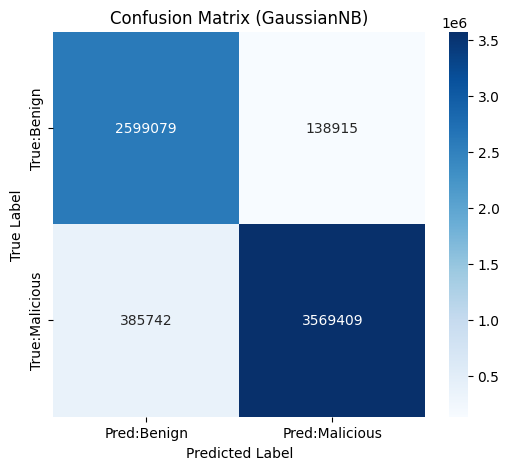

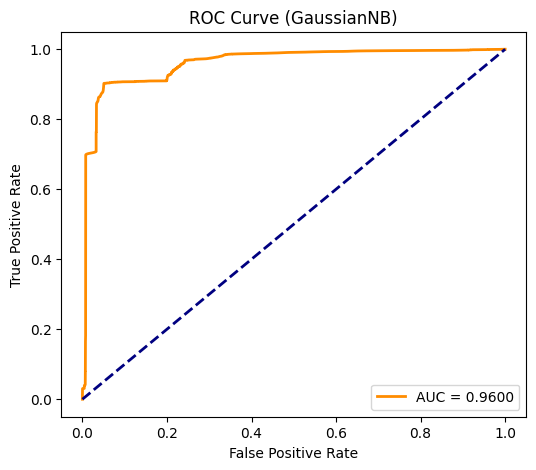

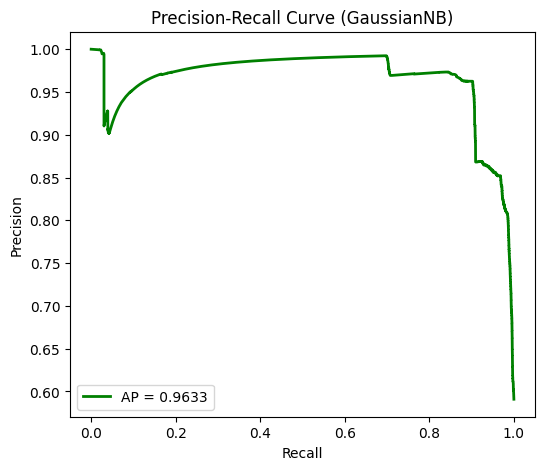

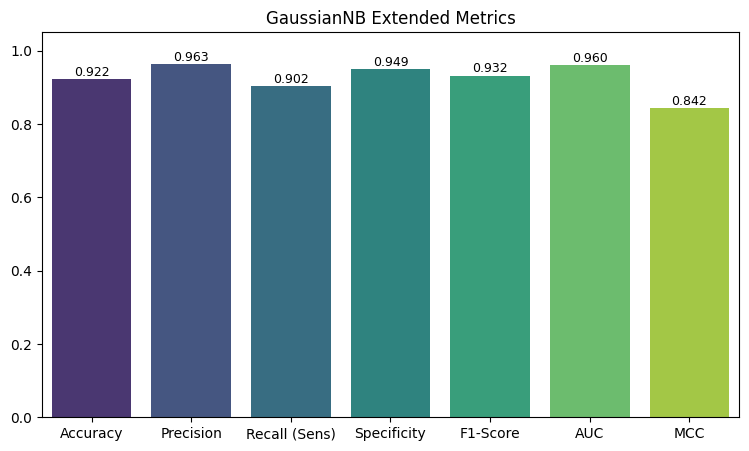

In [4]:
# ================== Extended Evaluation (Comprehensive Analysis) ==================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve,
    average_precision_score, cohen_kappa_score, matthews_corrcoef,
    classification_report
)

# --- Metrics at Best Threshold ---
y_pred = y_pred_opt  # from your tuned NB
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)
auc_score = auc(*roc_curve(y_true, mal_p)[:2])
ap = average_precision_score(y_true, mal_p)
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

# Sensitivity (Recall) and Specificity
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

# Create DataFrame with extended metrics
results_df = pd.DataFrame([{
    "Model": "GaussianNB",
    "Accuracy": round(acc,4),
    "Precision": round(prec,4),
    "Recall (Sensitivity)": round(sensitivity,4),
    "Specificity": round(specificity,4),
    "F1-Score": round(f1,4),
    "AUC": round(auc_score,4),
    "Average Precision": round(ap,4),
    "Cohen Kappa": round(kappa,4),
    "MCC": round(mcc,4)
}])

print("=== Extended Model Evaluation Results ===")
display(results_df)

# --- Classification Report ---
print("\n=== Classification Report (per class) ===")
print(classification_report(y_true, y_pred, target_names=["benign","malicious"], digits=4))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred:Benign","Pred:Malicious"],
            yticklabels=["True:Benign","True:Malicious"])
plt.title("Confusion Matrix (GaussianNB)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_true, mal_p)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"AUC = {auc_score:.4f}")
plt.plot([0,1],[0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (GaussianNB)")
plt.legend(loc="lower right")
plt.show()

# --- Precision-Recall Curve ---
prec_curve, rec_curve, _ = precision_recall_curve(y_true, mal_p)
plt.figure(figsize=(6,5))
plt.plot(rec_curve, prec_curve, color="green", lw=2,
         label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (GaussianNB)")
plt.legend(loc="lower left")
plt.show()

# --- Bar Chart of Metrics ---
plt.figure(figsize=(9,5))
metrics = ["Accuracy","Precision","Recall (Sens)","Specificity","F1-Score","AUC","MCC"]
values = [acc, prec, sensitivity, specificity, f1, auc_score, mcc]
sns.barplot(x=metrics, y=values, palette="viridis")
plt.ylim(0,1.05)
plt.title("GaussianNB Extended Metrics")
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontsize=9)
plt.show()